In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
%%bash
cd ..
rm -rf content
ln -s /drive/MyDrive/cs182_project content
cd content

pip install -r requirements.txt

# RESTART YOUR RUNTIME NOW!

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from segtok import tokenizer

In [2]:
# Key Hyperparameters
max_tokenized_length = 64
enable_orig = False
enable_aug = False
enable_aug3 = True

batch_size = 8
epochs = 5

experiment_id = "classification-bert-64-tokens-5-epochs-aug3-only"

In [3]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
assert not os.path.exists(experiment_dir)
os.makedirs(experiment_dir)

In [4]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [5]:
from training_utils import split_train_validation
train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

if not enable_orig:
    train_x = []
    train_y = []

if enable_aug:
    aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
    train_x += [i[0] for i in aug_data]
    train_y += [i[1] for i in aug_data]

if enable_aug3:
    aug_data3 = load_gen_dataset("./new_data3.json")
    train_x += [i[0] for i in aug_data3]
    train_y += [i[1] for i in aug_data3]

In [6]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [7]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [8]:
train_x_numerized = []
train_x_mask = []
for text in tqdm(train_x):
    tokenized = tokenizer(text, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
    train_x_numerized.append(tokenized.ids)
    train_x_mask.append(tokenized.attention_mask)
valid_x_numerized = []
valid_x_mask = []
for text in tqdm(valid_x):
    tokenized = tokenizer(text, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
    valid_x_numerized.append(tokenized.ids)
    valid_x_mask.append(tokenized.attention_mask)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5336 [00:00<?, ?it/s]

In [9]:
import numpy as np

train_x_numerized = np.array(train_x_numerized)
train_x_mask = np.array(train_x_mask)
train_y = np.array(train_y)
valid_x_numerized = np.array(valid_x_numerized)
valid_x_mask = np.array(valid_x_mask)
valid_y = np.array(valid_y)

from utils import memo_load
(train_x_numerized, train_x_mask, train_y, valid_x_numerized, valid_x_mask, valid_y) = memo_load(
    lambda: (train_x_numerized, train_x_mask, train_y, valid_x_numerized, valid_x_mask, valid_y),
    f"{experiment_dir}/training_data"
)

In [10]:
from model import ReviewPredictionModel
import torch as th
import torch.optim as optim

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

model_to_train = None
model_to_train = ReviewPredictionModel(0, max_tokenized_length)
model_to_train.to(device)
optimizer = optim.Adam(model_to_train.parameters(), lr=1e-5)

cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [11]:
from training_utils import run_training_loop

training_accuracies, validation_accuracies = run_training_loop(
    model_to_train, optimizer, device,
    batch_size, epochs,
    train_x_numerized, train_x_mask, train_y, valid_x_numerized, valid_x_mask, valid_y,
    model_id=experiment_id
)

from utils import memo_load
(training_accuracies, validation_accuracies) = memo_load(
    lambda: (training_accuracies, validation_accuracies),
    f"{experiment_dir}/training_validation_accuracies"
)

Epoch: 0 Iteration: 624 Loss: 1.002 Validation Loss: 4.595 Accuracy: 0.500 Validation Accuracy: 0.105: 100%|██████████| 626/626 [00:25<00:00, 24.78it/s]


Saving BERT model to ./bert_model_save_from_training/classification-bert-64-tokens-5-epochs-aug3-only/


Epoch: 1 Iteration: 624 Loss: 0.892 Validation Loss: 5.418 Accuracy: 0.388 Validation Accuracy: 0.113: 100%|██████████| 626/626 [00:26<00:00, 23.91it/s]


Saving BERT model to ./bert_model_save_from_training/classification-bert-64-tokens-5-epochs-aug3-only/


Epoch: 2 Iteration: 624 Loss: 0.780 Validation Loss: 5.867 Accuracy: 0.688 Validation Accuracy: 0.111: 100%|██████████| 626/626 [00:26<00:00, 23.67it/s]


Saving BERT model to ./bert_model_save_from_training/classification-bert-64-tokens-5-epochs-aug3-only/


Epoch: 3 Iteration: 624 Loss: 0.632 Validation Loss: 6.432 Accuracy: 0.713 Validation Accuracy: 0.116: 100%|██████████| 626/626 [00:26<00:00, 23.91it/s]


Saving BERT model to ./bert_model_save_from_training/classification-bert-64-tokens-5-epochs-aug3-only/


Epoch: 4 Iteration: 624 Loss: 0.408 Validation Loss: 6.972 Accuracy: 0.863 Validation Accuracy: 0.113: 100%|██████████| 626/626 [00:26<00:00, 24.03it/s]


Saving BERT model to ./bert_model_save_from_training/classification-bert-64-tokens-5-epochs-aug3-only/


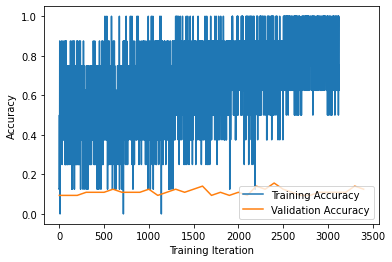

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{experiment_dir}/training-plot.png")